In [1]:
#import kagglehub

# Download latest version
#path = kagglehub.dataset_download("gabrielmanfredi/football-players-ratings")
#print("Path to dataset files:", path)

# Importation des packages et du Dataset

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.feature_selection import mutual_info_regression

In [4]:
df = pd.read_csv('data_football_ratings.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50652 entries, 0 to 50651
Data columns (total 63 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   competition             50652 non-null  object 
 1   date                    50652 non-null  object 
 2   match                   50652 non-null  object 
 3   team                    50652 non-null  object 
 4   pos                     50652 non-null  object 
 5   pos_role                50652 non-null  object 
 6   player                  50652 non-null  object 
 7   rater                   50652 non-null  object 
 8   is_human                50652 non-null  int64  
 9   original_rating         50652 non-null  float64
 10  goals                   50652 non-null  int64  
 11  assists                 50652 non-null  int64  
 12  shots_ontarget          50652 non-null  int64  
 13  shots_offtarget         50652 non-null  int64  
 14  shotsblocked            50652 non-null

# Découverte du Dataset

# Statistiques descriptives

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50652 entries, 0 to 50651
Data columns (total 63 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   competition             50652 non-null  object 
 1   date                    50652 non-null  object 
 2   match                   50652 non-null  object 
 3   team                    50652 non-null  object 
 4   pos                     50652 non-null  object 
 5   pos_role                50652 non-null  object 
 6   player                  50652 non-null  object 
 7   rater                   50652 non-null  object 
 8   is_human                50652 non-null  int64  
 9   original_rating         50652 non-null  float64
 10  goals                   50652 non-null  int64  
 11  assists                 50652 non-null  int64  
 12  shots_ontarget          50652 non-null  int64  
 13  shots_offtarget         50652 non-null  int64  
 14  shotsblocked            50652 non-null

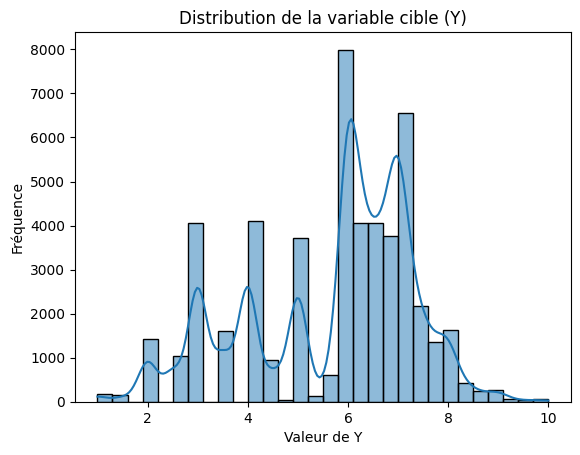

In [5]:
sns.histplot(df['original_rating'], kde=True, bins=30)
plt.title("Distribution de la variable cible (Y)")
plt.xlabel("Valeur de Y")
plt.ylabel("Fréquence")
plt.show()

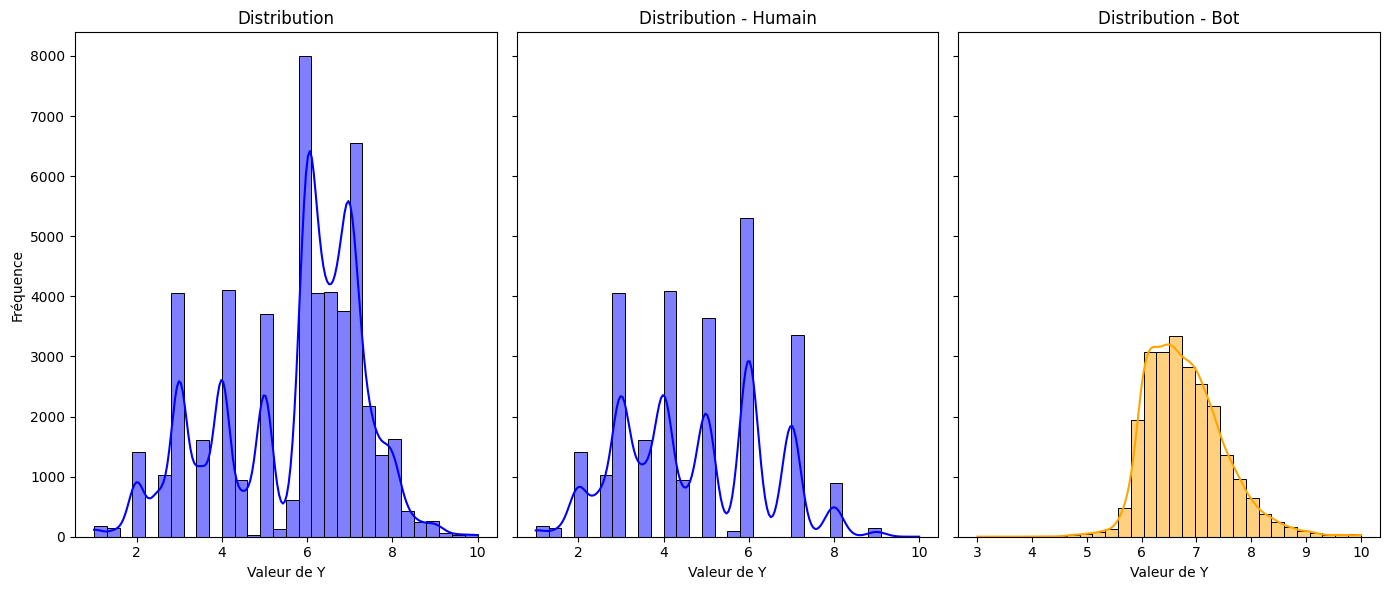

In [5]:
df_human = df[df['is_human']==1]
df_bot = df[df['is_human']==0]

# Créer un subplot avec deux graphiques côte à côte
fig, axes = plt.subplots(1, 3, figsize=(14, 6), sharey=True)

# Distribution des humains
sns.histplot(df['original_rating'], kde=True, bins=30, ax=axes[0], color='blue')
axes[0].set_title("Distribution")
axes[0].set_xlabel("Valeur de Y")
axes[0].set_ylabel("Fréquence")

# Distribution des humains
sns.histplot(df_human['original_rating'], kde=True, bins=30, ax=axes[1], color='blue')
axes[1].set_title("Distribution - Humain")
axes[1].set_xlabel("Valeur de Y")
axes[1].set_ylabel("Fréquence")

# Distribution des bots
sns.histplot(df_bot['original_rating'], kde=True, bins=30, ax=axes[2], color='orange')
axes[2].set_title("Distribution - Bot")
axes[2].set_xlabel("Valeur de Y")
axes[2].set_ylabel("Fréquence")

plt.tight_layout()
plt.show()

Il est intéressant d'observer que les bots ont tendances à attribuer des notes élevées avec une distribution en cloche et avec peu de disparitées (s'expliquant par un éventuel biais auto entretenu?) tandis la notation humaine contient plus de disparité et est souvent discrète.

**Lien entre Team et journal de notation ?**

In [6]:
df['team'].unique()

array(['Romania', 'France', 'Russia', 'Slovakia', 'Wales', 'Switzerland',
       'Albania', 'England', 'Croatia', 'Turkey', 'Poland', 'Germany',
       'Northern Ireland', 'Ukraine', 'Ireland', 'Belgium',
       'Czech Republic', 'Sweden', 'Spain', 'Italy', 'Iceland', 'Hungary',
       'Portugal', 'Austria', 'Arsenal', 'Leicester', 'Huddersfield',
       'Burnley', 'West Bromwich Albion', 'Manchester City', 'Everton',
       'Stoke', 'Watford', 'Southampton', 'Liverpool', 'Swansea',
       'Bournemouth', 'Crystal Palace', 'Brighton', 'Chelsea',
       'Manchester United', 'Tottenham', 'Newcastle United', 'West Ham',
       'Bayer Leverkusen', 'Bayern Munich', 'Wolfsburg', 'Schalke 04',
       'Hamburger SV', 'Werder Bremen', 'RasenBallsport Leipzig',
       'Hannover 96', 'Borussia Dortmund', 'VfB Stuttgart', 'Augsburg',
       'Mainz 05', 'Hoffenheim', 'Hertha Berlin', 'Borussia M.Gladbach',
       'FC Koln', 'Eintracht Frankfurt', 'Freiburg', 'Saudi Arabia',
       'Iran', 'Morocco',

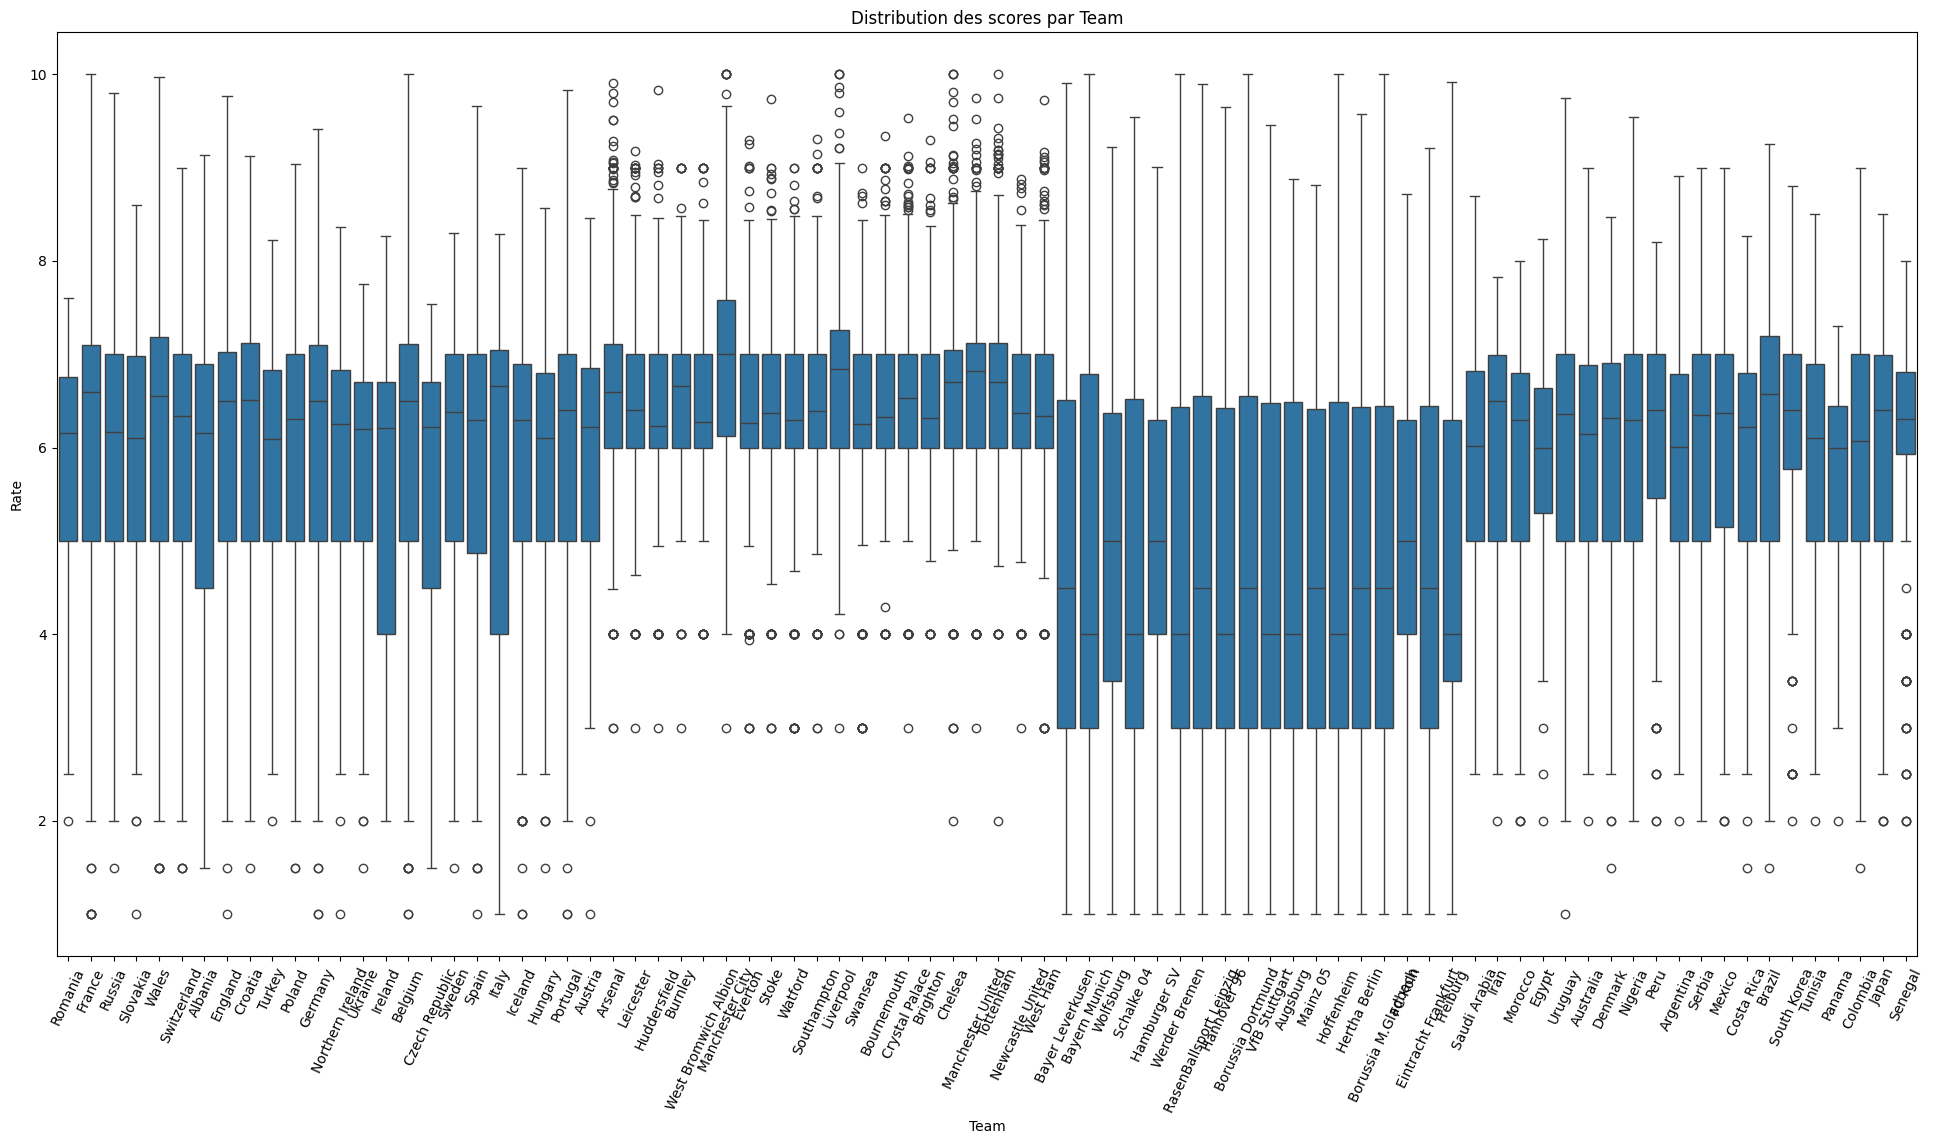

In [24]:
# Tracer les boxplots pour chaque team
plt.figure(figsize=(24, 12))
sns.boxplot(data=df, x='team', y='original_rating')
plt.title('Distribution des scores par Team')
plt.xlabel('Team')
plt.ylabel('Rate')
plt.xticks(rotation=65)
plt.show()

In [26]:
df['rater'].unique()

array(['Kicker', 'WhoScored', 'SofaScore', 'TheGuardian', 'SkySports',
       'Bild'], dtype=object)

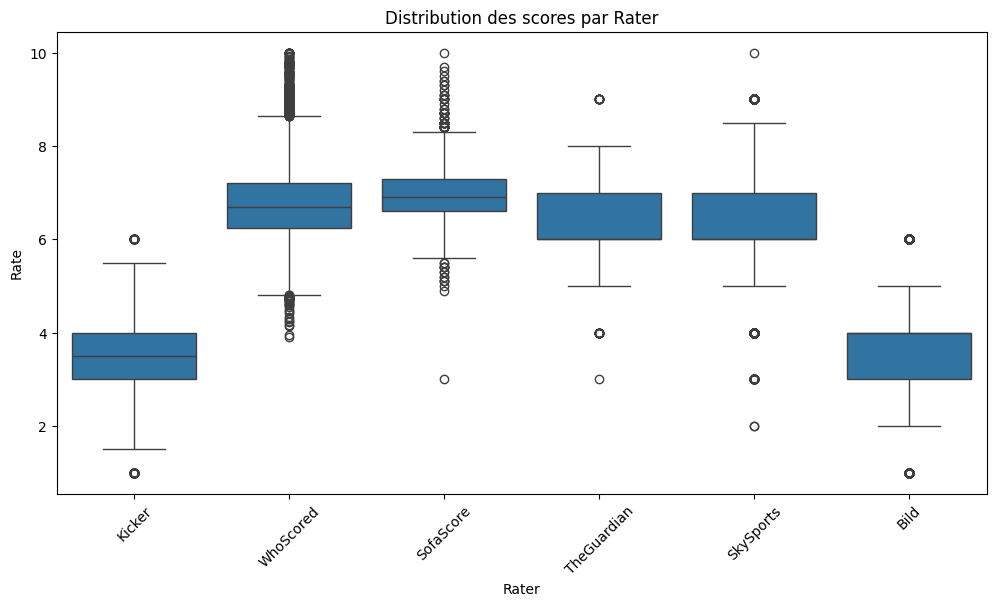

In [8]:
# Tracer les boxplots pour chaque rater
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='rater', y='original_rating')
plt.title('Distribution des scores par Rater')
plt.xlabel('Rater')
plt.ylabel('Rate')
plt.xticks(rotation=45)
plt.show()

Il est intéressant d'observer qu'il existent des disparitées importantes entre les évaluateurs. Nous pouvons distinguer deux groupes.

**Creation des dummies**

In [15]:
#Création de dummies pour retirer les informations des chaines de caractères (compétition, équipe, poste, poste principal ?, évaluateur)
columns_to_dummies = ['competition', 'team', 'pos', 'pos_role', 'rater']
df = pd.get_dummies(df, columns=columns_to_dummies, prefix=columns_to_dummies)

In [16]:
# Nous créons une colonne qui permet de vérifier le nombre d'occurence par joueur
# Cette variable permettra de rendre non sensible nos prédictions à la moyenne car si le joueur apparait une fois il a possibilité d'afficher des performances élevées par chance contrairement aux joueurs jouant plus souvent. Le nombre de fois où un joueur joue peut être signe de bonne perf.

df['nombre_apparitions'] = df['player'].map(df['player'].value_counts())

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


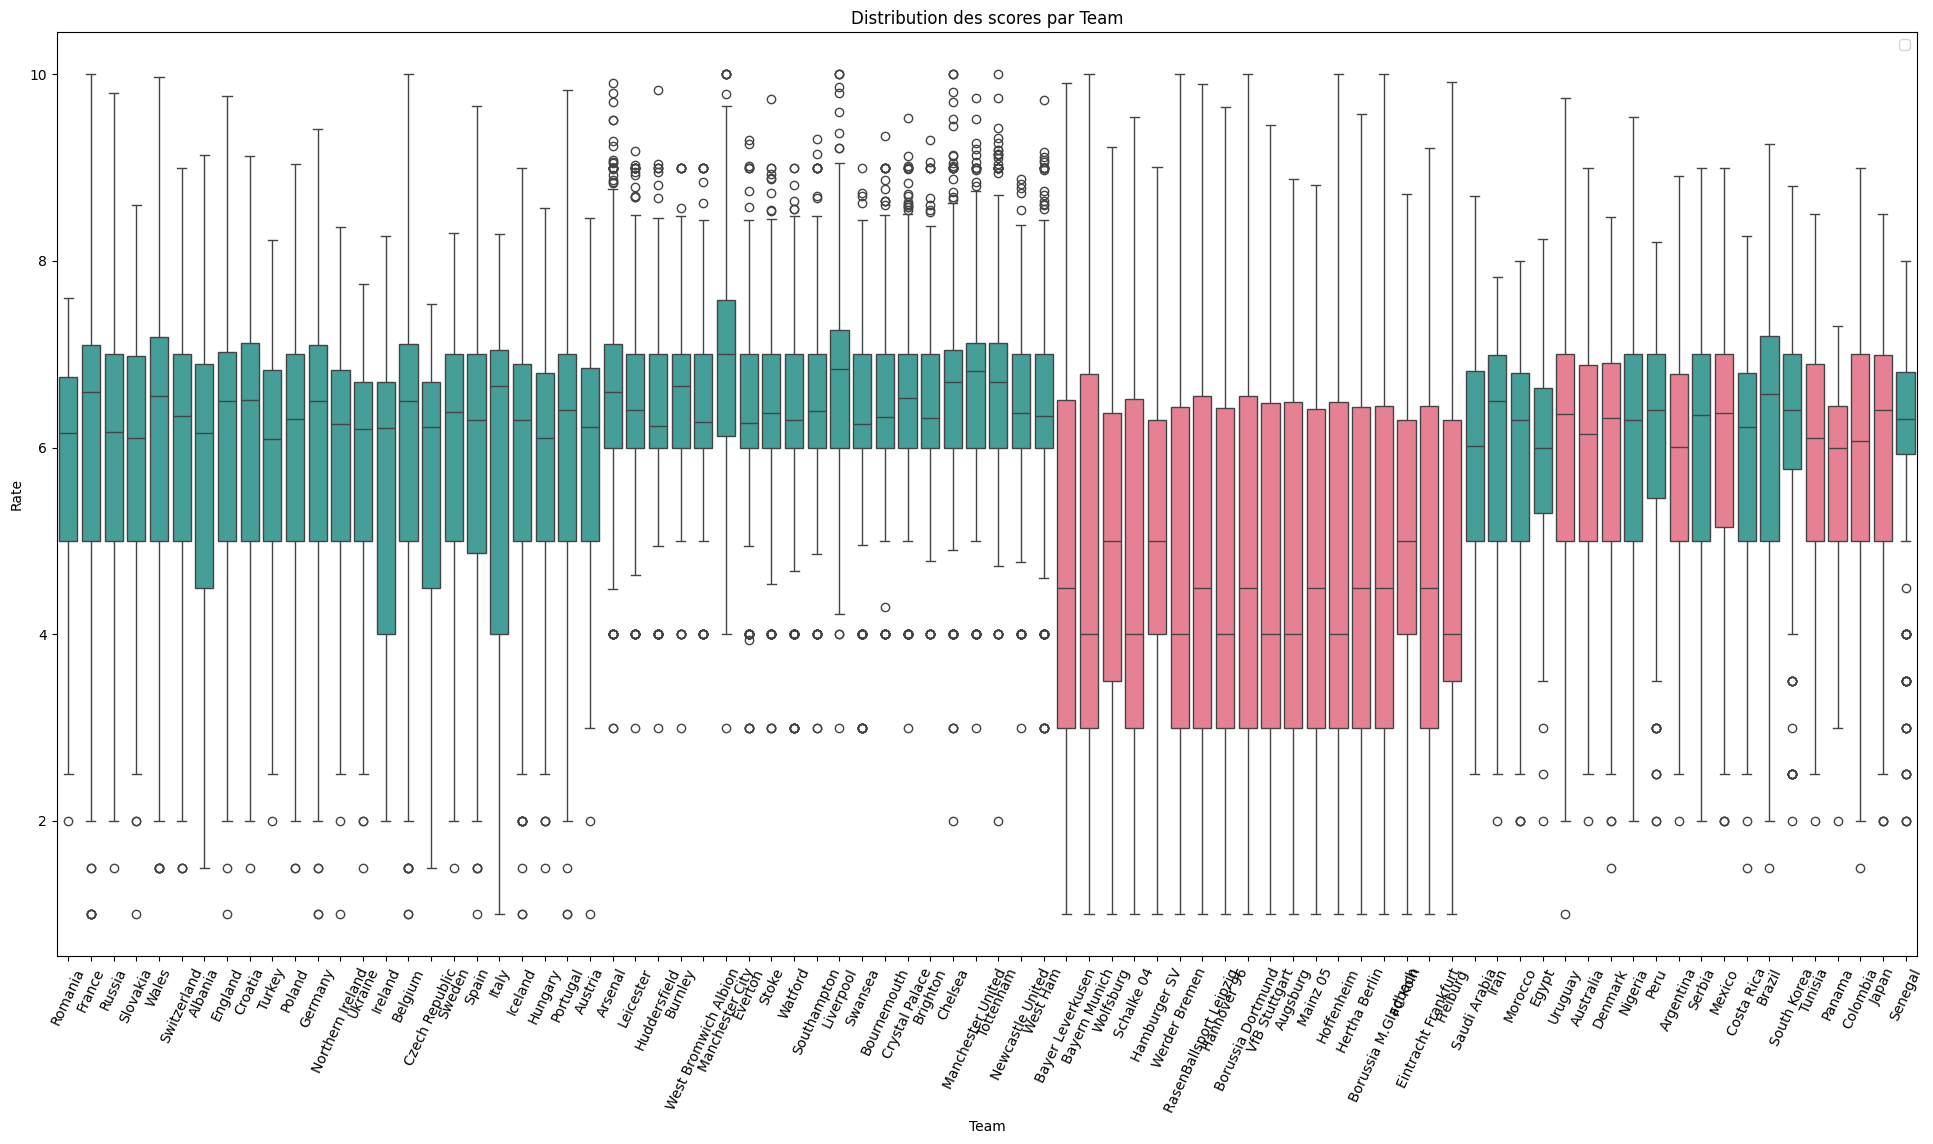

In [13]:
# Générer un dictionnaire de couleurs unique pour chaque journal
unique_journals = df['is_human'].unique()
palette = sns.color_palette("husl", len(unique_journals))
journal_colors = {journal: palette[i] for i, journal in enumerate(unique_journals)}

# Déterminer le journal majoritaire pour chaque team
team_major_journal = df.groupby('team')['is_human'].agg(lambda x: x.value_counts().idxmax())

# Associer une couleur unique à chaque team en fonction du journal majoritaire
team_colors = {team: journal_colors[team_major_journal[team]] for team in df['team'].unique()}

# Tracer les boxplots pour chaque team avec les couleurs correspondantes
plt.figure(figsize=(24, 12))
sns.boxplot(data=df, x='team', y='original_rating', hue='team', palette=team_colors, dodge=False)
plt.title('Distribution des scores par Team')
plt.xlabel('Team')
plt.ylabel('Rate')
plt.xticks(rotation=65)
plt.legend()
plt.show()

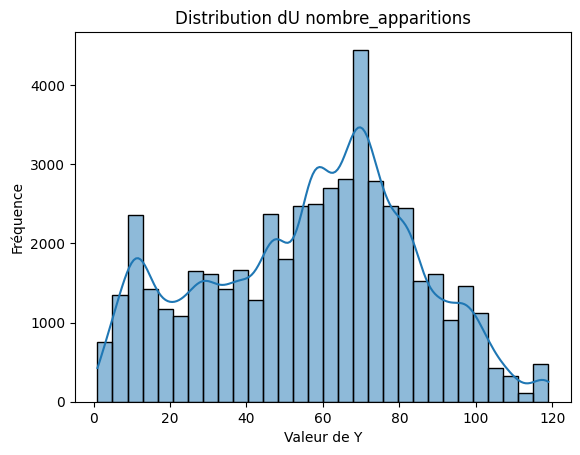

In [11]:
sns.histplot(df['nombre_apparitions'], kde=True, bins=30)
plt.title("Distribution dU nombre_apparitions")
plt.xlabel("Valeur de Y")
plt.ylabel("Fréquence")
plt.show()

Nous pouvons voir effectivement qu'il y a beaucoup de disparité et qu'il est nécessaire que l'algorithme de prédiction utilisé prennent en compte cette variabilité pour ne pas pénaliser la note prédite d'un joueur qui joue fréquemment.

In [ ]:
def extract_opponent_and_scores(match_str, team):
    """
    Returns (opp_team, team_score, opp_score).
    - match_str : "France - Romania, 2 - 1"
    - team      : name of the team (e.g., "France" or "Romania")
    """
    pattern = re.compile(r"^([^-]+)\s*-\s*([^,]+),\s*(\d+)\s*-\s*(\d+)$")f
    match = pattern.match(match_str)
    if match:
        team1 = match.group(1).strip()
        team2 = match.group(2).strip()
        score1 = int(match.group(3))
        score2 = int(match.group(4))

        if team == team1:
            return (team2, score1, score2)
        elif team == team2:
            return (team1, score2, score1)
        else:
            return (None, None, None)
    else:
        return (None, None, None)

# Create new columns with the extracted infos
df['opp_team'], df['team_score'], df['opp_score'] = zip(*df.apply(
    lambda row: extract_opponent_and_scores(row['match'], row['team']), axis=1
))

df[['match', 'team', 'opp_team', 'team_score', 'opp_score']].head()

In [ ]:
def extract_year(date_str):
    """
    Takes as input a string representing a date in the format mm/dd/yyyy.
    Returns the year ('yyyy') or None if nothing is found.
    """
    pattern = re.compile(r"\b(\d{4})\b")
    match = pattern.search(date_str)
    if match:
        return match.group(1)
    else:
        return None

df['year'] = df['date'].apply(extract_year)
df[['date', 'year']].head()

# Manipulation des tables

Les joueurs étant notés plusieurs fois, nous optons pour établir une moyenne des caractéristiques des joueurs. De ce fait les prédictions de notes de joueurs seront basées sur une moyenne, nous poserons dans un premier temps l'hypothèse forte que les prédicteurs suivent une loi normale et que par conséquent les predictions ne seront pas sensibles aux valeurs extrêmes (d'une autre mesure nous pourrions également jouer sur la médiane).

Nous disposerons donc d'un dataframe avec une ligne par joueur.

In [18]:
df = df.drop(columns=['date', 'match'])

In [13]:
df_avg = df.groupby('player', as_index=False).mean()
df_med = df.groupby('player', as_index=False).median()
print("Nous travaillerons donc avec", len(df_avg), "joueurs")

Nous travaillerons donc avec 1632 joueurs


In [18]:
df.to_csv('football_ratings_cleaned.csv')
df_avg.to_csv('avg_football_ratings_cleaned.csv')
df_med.to_csv('med_football_ratings_cleaned.csv')

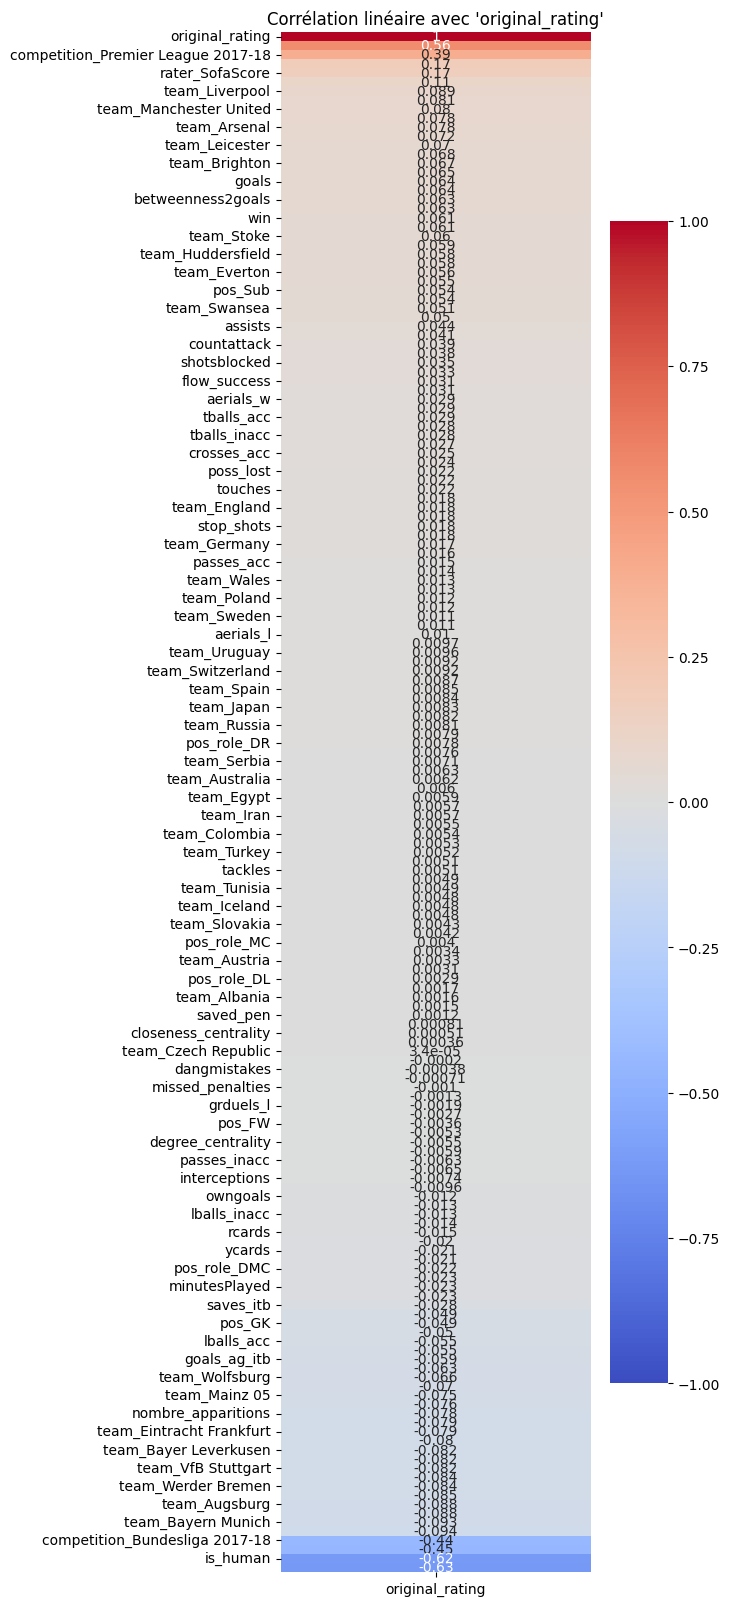

C:\Users\valen\AppData\Local\Temp\ipykernel_26196\4218716819.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Mutual Information', y='Feature', data=mi_scores_df, palette='coolwarm')


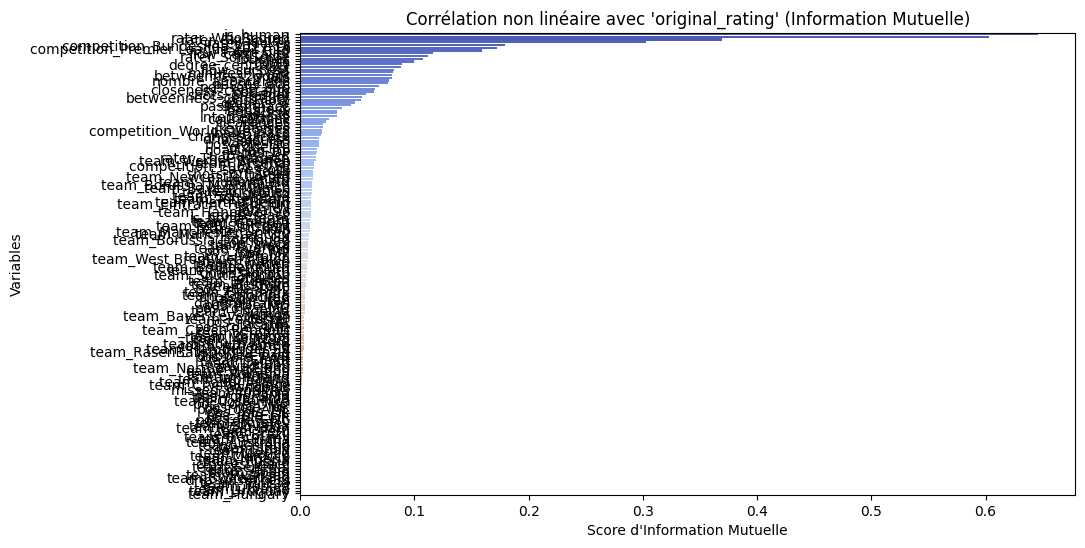

In [22]:
# Exclure la colonne 'player'
df_no_player = df.drop(columns=['player'])

# Calculer la corrélation linéaire (Pearson) entre 'original_rating' et les autres variables
correlation = df_no_player.corr()[['original_rating']].sort_values(by='original_rating', ascending=False)

# Créer une heatmap des corrélations linéaires
plt.figure(figsize=(5, 20))
sns.heatmap(correlation, annot=True, cmap='coolwarm', cbar=True, vmin=-1, vmax=1)
plt.title("Corrélation linéaire avec 'original_rating'")
plt.show()

# Calculer la corrélation non linéaire avec l'information mutuelle
X = df_no_player.drop(columns=['original_rating'])  # Variables indépendantes
y = df_no_player['original_rating']  # Variable cible

# Normalisation des données pour éviter les biais
X = X.apply(lambda x: (x - x.min()) / (x.max() - x.min()) if x.dtype in ['int64', 'float64'] else x)

# Calculer l'information mutuelle
mi_scores = mutual_info_regression(X, y)
mi_scores_df = pd.DataFrame({'Feature': X.columns, 'Mutual Information': mi_scores})
mi_scores_df = mi_scores_df.sort_values(by='Mutual Information', ascending=False)

# Créer un barplot des scores d'information mutuelle
plt.figure(figsize=(10, 6))
sns.barplot(x='Mutual Information', y='Feature', data=mi_scores_df, palette='coolwarm')
plt.title("Corrélation non linéaire avec 'original_rating' (Information Mutuelle)")
plt.xlabel("Score d'Information Mutuelle")
plt.ylabel("Variables")
plt.show()


Nous allons opter dans un premier temps sur la sélection des variables avec une corrélation supérieur à 0.1 et inférieur à -0,1

In [15]:
Y = df_avg['original_rating'] #Variable continue
X = df_avg[['rater_SkySports','competition_Premier League 2017-18','rater_WhoScored','team_Manchester City',#Effets positifs
           'team_Tottenham','team_Liverpool','team_Manchester United','team_Burnley','team_England','team_Southampton',
           'team_Newcastle United','competition_World Cup 2018','team_Arsenal','team_Crystal Palace','rater_SofaScore','team_Leicester','team_Watford',
           'nombre_apparitions','team_Hannover 96','team_Hamburger SV','team_Wolfsburg','team_Schalke 04','team_Bayer Leverkusen','team_VfB Stuttgart',#Effets négatifs
           'team_Augsburg','team_Hertha Berlin','team_RasenBallsport Leipzig','team_Borussia Dortmund','team_Mainz 05','team_Werder Bremen',
           'team_Bayern Munich','team_Freiburg', 'team_Hoffenheim','is_human','rater_Kicker','competition_Bundesliga 2017-18','rater_Bild']]

Y = df['original_rating'] #Variable continue
X = df[['rater_SkySports','competition_Premier League 2017-18','rater_WhoScored','team_Manchester City',#Effets positifs
           'team_Tottenham','team_Liverpool','team_Manchester United','team_Burnley','team_England','team_Southampton',
           'team_Newcastle United','competition_World Cup 2018','team_Arsenal','team_Crystal Palace','rater_SofaScore','team_Leicester','team_Watford',
           'nombre_apparitions','team_Hannover 96','team_Hamburger SV','team_Wolfsburg','team_Schalke 04','team_Bayer Leverkusen','team_VfB Stuttgart',#Effets négatifs
           'team_Augsburg','team_Hertha Berlin','team_RasenBallsport Leipzig','team_Borussia Dortmund','team_Mainz 05','team_Werder Bremen',
           'team_Bayern Munich','team_Freiburg', 'team_Hoffenheim','is_human','rater_Kicker','competition_Bundesliga 2017-18','rater_Bild']]

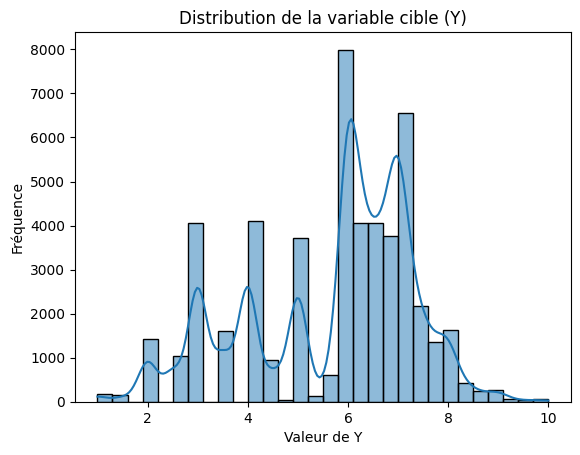

In [16]:
sns.histplot(Y, kde=True, bins=30)
plt.title("Distribution de la variable cible (Y)")
plt.xlabel("Valeur de Y")
plt.ylabel("Fréquence")
plt.show()

Il est intéressant d'observer que après regroupement par joueurs avec les notes moyennes, nous retrouvons distribution contenant deux groupes:

-Un groupe avec de meilleurs notes (moyenne à 6)

-Un autre groupe avec de moins bonnes notes (moyenne à 4,8)

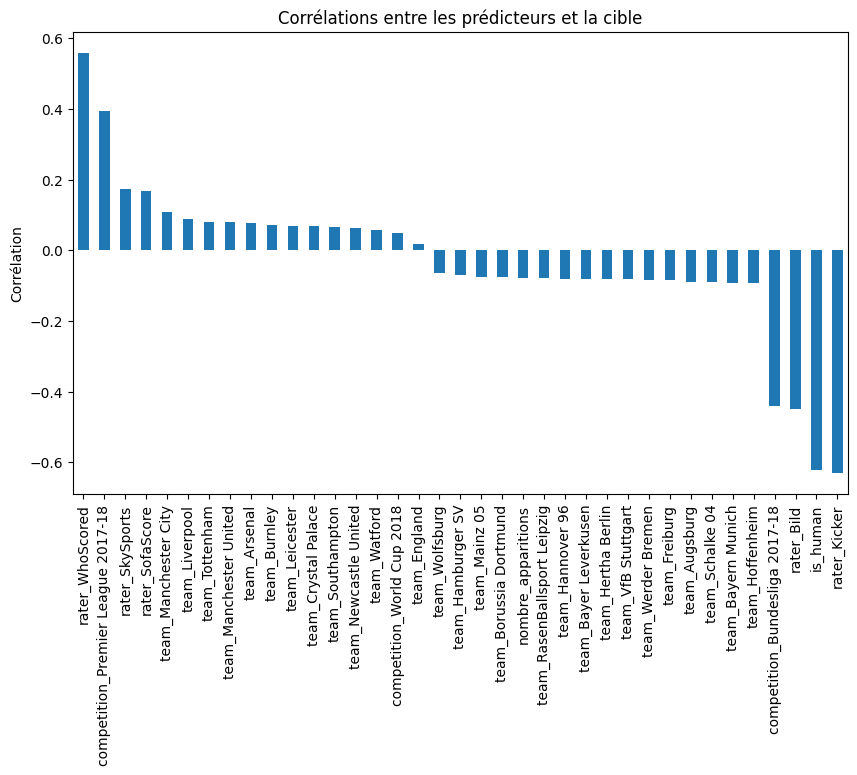

In [17]:
correlations = X.corrwith(Y).sort_values(ascending=False)
correlations.plot(kind='bar', figsize=(10, 6))
plt.title("Corrélations entre les prédicteurs et la cible")
plt.ylabel("Corrélation")
plt.show()